# Imports libraries

In [215]:
import seaborn as sns
import spacy
import re
import os
import numpy as np
import pandas as pd
import copy
!pip install gensim
import gensim
import matplotlib.pyplot as plt

from scipy import sparse
from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from IPython.display import Image
from spacy import displacy
from transformers import pipeline
%matplotlib inline
from nltk import word_tokenize
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from urllib import request
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.svm import SVR
from itertools import chain
from copy import deepcopy
from tqdm import tqdm

In [216]:
import nltk
import warnings
from nltk.corpus import wordnet
from nltk.corpus import stopwords

In [217]:
!cp -r ../input/sentence-transformers-dataset/sentence-transformers /tmp/st
!pip install /tmp/st

Processing /tmp/st
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=126132 sha256=c7bd49f8252b19c98cc2f0645848743bb67f32558007fe10680c41a83d233861
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pw1kgua/wheels/75/66/b4/7e3615e01e698b0515db7fe537d95df69218ed36339b7dfb5d
Successfully built sentence-transformers
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.2
    Uninstalling sentence-transformers-2.2.2:
      Successfully uninstalled sentence-transformers-2.2.2


In [218]:
from sentence_transformers import SentenceTransformer, util

# Data Understanding

In [219]:
summaries_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
prompts_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
sample_submission = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")

In [220]:
summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [221]:
summaries_test.head()

,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [222]:
prompts_train.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [223]:
prompts_test.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


In [224]:
sample_submission.head()

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [225]:
summaries_train.dtypes

student_id     object
prompt_id      object
text           object
content       float64
wording       float64
dtype: object

In [226]:
summaries_test.dtypes

student_id    object
prompt_id     object
text          object
dtype: object

In [227]:
prompts_train.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [228]:
prompts_test.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [229]:
sample_submission.dtypes

student_id     object
content       float64
wording       float64
dtype: object

****
1. Test dataset hasn't any real data, so we need to made validation dataset by hand.

****

**I commented part of my code for faster commit in Kaggle**

In [230]:
'''sns.kdeplot(data = summaries_train, x = "content", color = "b", alpha = .5, fill = True)
plt.title("Content distribution")
plt.grid()'''

'sns.kdeplot(data = summaries_train, x = "content", color = "b", alpha = .5, fill = True)\nplt.title("Content distribution")\nplt.grid()'

boxplots

In [231]:
'''sns.boxplot(x = summaries_train['content'])'''

"sns.boxplot(x = summaries_train['content'])"

In [232]:
'''sns.kdeplot(data = summaries_train, x = "wording",color = "r", alpha = .5, fill = True)
plt.title("Wording distribution")
plt.grid()'''

'sns.kdeplot(data = summaries_train, x = "wording",color = "r", alpha = .5, fill = True)\nplt.title("Wording distribution")\nplt.grid()'

In [233]:
'''sns.boxplot(x = summaries_train['wording'])'''

"sns.boxplot(x = summaries_train['wording'])"

In [234]:
Q1 = summaries_train['wording'].quantile(0.25)
Q3 = summaries_train['wording'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to keep only the rows within the bounds
summaries_train = summaries_train[(summaries_train['wording'] >= lower_bound) & (summaries_train['wording'] <= upper_bound)]

In [235]:
Q1 = summaries_train['content'].quantile(0.25)
Q3 = summaries_train['content'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to keep only the rows within the bounds
summaries_train = summaries_train[(summaries_train['content'] >= lower_bound) & (summaries_train['content'] <= upper_bound)]

In [236]:
summaries_train = summaries_train.merge(prompts_train , on = "prompt_id")
summaries_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,014e2395b3c4,814d6b,The Thrid Wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


In [237]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def count_stopwords(text, stopwords):
    split = text.lower().split(' ')
    count = 0
    for i in split:
        if i in stopwords:
            count += 1
    return count


In [238]:
summaries_train["stopwords"] = summaries_train['text'].apply(count_stopwords, stopwords = stop_words)
summaries_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,stopwords
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,25
1,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27
2,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,35
3,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,12
4,014e2395b3c4,814d6b,The Thrid Wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,67
...,...,...,...,...,...,...,...,...,...
6947,fef3e85236e5,39c16e,"It has to be made on a complex storyline, with...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,16
6948,ff0f65eecf02,39c16e,Aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,15
6949,ff186473ea0a,39c16e,A tragedy should have a complex plan not a sim...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,16
6950,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,22


In [239]:
'''sns.kdeplot(data = summaries_train, x = "wording", y = "stopwords",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of stopwords")
plt.ylabel("Total words")
plt.grid()'''

'sns.kdeplot(data = summaries_train, x = "wording", y = "stopwords",color = "r", alpha = .9, fill = True)\nplt.title("Wording distribution vs total of stopwords")\nplt.ylabel("Total words")\nplt.grid()'

In [240]:
'''sns.kdeplot(data = summaries_train, x = "content", y = "stopwords",color = "b", alpha = .9, fill = True)
plt.title("Wording distribution vs total of stopwords")
plt.ylabel("Total words")
plt.grid()'''

'sns.kdeplot(data = summaries_train, x = "content", y = "stopwords",color = "b", alpha = .9, fill = True)\nplt.title("Wording distribution vs total of stopwords")\nplt.ylabel("Total words")\nplt.grid()'

In [241]:
summaries_train["punctuation"] = summaries_train['text'].str.count(r'[\.,\n]')
summaries_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,stopwords,punctuation
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,25,3
1,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,5
2,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,35,8
3,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,12,2
4,014e2395b3c4,814d6b,The Thrid Wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,67,5
...,...,...,...,...,...,...,...,...,...,...
6947,fef3e85236e5,39c16e,"It has to be made on a complex storyline, with...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,16,1
6948,ff0f65eecf02,39c16e,Aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,15,3
6949,ff186473ea0a,39c16e,A tragedy should have a complex plan not a sim...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,16,3
6950,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,22,4


In [242]:
'''sns.kdeplot(data = summaries_train, x = "wording", y = "punctuation",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of punctuation")
plt.ylabel("Total punctuation")
plt.grid()'''

'sns.kdeplot(data = summaries_train, x = "wording", y = "punctuation",color = "r", alpha = .9, fill = True)\nplt.title("Wording distribution vs total of punctuation")\nplt.ylabel("Total punctuation")\nplt.grid()'

In [243]:
'''sns.kdeplot(data = summaries_train, x = "wording", y = "punctuation",color = "b", alpha = .9, fill = True)
plt.title("Wording distribution vs total of punctuation")
plt.ylabel("Total punctuation")
plt.grid()'''

'sns.kdeplot(data = summaries_train, x = "wording", y = "punctuation",color = "b", alpha = .9, fill = True)\nplt.title("Wording distribution vs total of punctuation")\nplt.ylabel("Total punctuation")\nplt.grid()'

# EDA

In [244]:
'''profile = ProfileReport(summaries_train, title="Profiling Report")
profile'''

'profile = ProfileReport(summaries_train, title="Profiling Report")\nprofile'

In [245]:
summaries_train['text'] = summaries_train['text'].str.lower().str.replace('[^a-z0-9 ]+', ' ', regex = True)
summaries_train['prompt_text'] = summaries_train['prompt_text'].str.lower().str.replace('[^a-z0-9 ]+', ' ', regex = True)
summaries_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,stopwords,punctuation
0,000e8c3c7ddb,814d6b,the third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,background the third wave experiment took pla...,25,3
1,0095993991fe,814d6b,the third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,background the third wave experiment took pla...,27,5
2,00c20c6ddd23,814d6b,the experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,background the third wave experiment took pla...,35,8
3,00d40ad10dc9,814d6b,the third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,background the third wave experiment took pla...,12,2
4,014e2395b3c4,814d6b,the thrid wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,background the third wave experiment took pla...,67,5
...,...,...,...,...,...,...,...,...,...,...
6947,fef3e85236e5,39c16e,it has to be made on a complex storyline with...,-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,chapter 13 as the sequel to what has already ...,16,1
6948,ff0f65eecf02,39c16e,aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,chapter 13 as the sequel to what has already ...,15,3
6949,ff186473ea0a,39c16e,a tragedy should have a complex plan not a sim...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,chapter 13 as the sequel to what has already ...,16,3
6950,ff5e9e6068da,39c16e,aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,chapter 13 as the sequel to what has already ...,22,4


In [246]:
def preprocess_hard(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and
            # len(token) > 2 and
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

****I had a problem with installing nltk, because I can't use internet at kaggle competitions. Unfortunately, I didn't use clean_text function****

In [247]:
'''wnl = WordNetLemmatizer()

def clean_text(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [wnl.lemmatize(word) for word in text if word not in stopwords.words('english')]
    text = " ".join(text)
    
    return text'''

'wnl = WordNetLemmatizer()\n\ndef clean_text(text):\n    text = re.sub("[^a-zA-Z]", " ", text)\n    text = text.lower().split()\n    text = [wnl.lemmatize(word) for word in text if word not in stopwords.words(\'english\')]\n    text = " ".join(text)\n    \n    return text'

In [248]:
summaries_train["text_without_stopwords"] = summaries_train['text'].apply(lambda x : preprocess_hard(x))
summaries_train["prompt_text"] = summaries_train['prompt_text'].apply(lambda x : preprocess_hard(x))
summaries_train["prompt_question"] = summaries_train['prompt_question'].apply(lambda x : preprocess_hard(x))
summaries_train["prompt_title"] = summaries_train['prompt_title'].apply(lambda x : preprocess_hard(x))

In [249]:
summaries_train["count_t"] = summaries_train["text_without_stopwords"].str.split().str.len() 
summaries_train["count_p"] = summaries_train["prompt_text"].str.split().str.len()
summaries_train["length_symbols"] = summaries_train["text_without_stopwords"].apply(len)
summaries_train["count_tp"] = summaries_train["count_t"] / summaries_train["count_p"]
summaries_train["mean_word_length"] = (summaries_train["length_symbols"] - summaries_train['count_t'] + 1) / summaries_train['count_t']

summaries_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,stopwords,punctuation,text_without_stopwords,count_t,count_p,length_symbols,count_tp,mean_word_length
0,000e8c3c7ddb,814d6b,the third wave was an experimentto see how peo...,0.205683,0.380538,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,25,3,wave experimentto people reacted new leader go...,31,282,224,0.109929,6.258065
1,0095993991fe,814d6b,the third wave only started as an experiment w...,0.205683,0.380538,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,27,5,wave started experiment class slowly spread ki...,27,282,194,0.095745,6.222222
2,00c20c6ddd23,814d6b,the experimen was orginally about how even whe...,0.567975,0.969062,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,35,8,experimen orginally terrible thngs happening f...,32,282,248,0.113475,6.781250
3,00d40ad10dc9,814d6b,the third wave developed so quickly due to the...,-0.910596,-0.081769,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,12,2,wave developed quickly students particip thos ...,13,282,90,0.046099,6.000000
4,014e2395b3c4,814d6b,the thrid wave movement in the school has more...,1.376083,2.389443,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,67,5,thrid wave movement school students join perio...,51,282,404,0.180851,6.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6947,fef3e85236e5,39c16e,it has to be made on a complex storyline with...,-0.981265,-1.548900,summarize elements ideal tragedy described ari...,tragedy,chapter sequel said proceed consider poet aim ...,16,1,complex storyline plot makes audience feel pit...,15,236,109,0.063559,6.333333
6948,ff0f65eecf02,39c16e,aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,summarize elements ideal tragedy described ari...,tragedy,chapter sequel said proceed consider poet aim ...,15,3,aristotle descirbes ideal tradgedy complex pla...,12,236,87,0.050847,6.333333
6949,ff186473ea0a,39c16e,a tragedy should have a complex plan not a sim...,-0.834946,-0.593749,summarize elements ideal tragedy described ari...,tragedy,chapter sequel said proceed consider poet aim ...,16,3,tragedy complex plan simple good plot plot exc...,10,236,59,0.042373,5.000000
6950,ff5e9e6068da,39c16e,aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,summarize elements ideal tragedy described ari...,tragedy,chapter sequel said proceed consider poet aim ...,22,4,aristotle believed ideal tradegy include purga...,27,236,201,0.114407,6.481481


In [250]:
'''sns.kdeplot(data = summaries_train, x = "wording", y = "count_tp",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of words ratio")
plt.ylabel("Total words ratio")
plt.grid()'''

'sns.kdeplot(data = summaries_train, x = "wording", y = "count_tp",color = "r", alpha = .9, fill = True)\nplt.title("Wording distribution vs total of words ratio")\nplt.ylabel("Total words ratio")\nplt.grid()'

In [251]:
'''sns.kdeplot(data = summaries_train, x = "content", y = "count_tp",color = "b", alpha = .9, fill = True)
plt.title("Content distribution vs total of words")
plt.ylabel("Total words")
plt.grid()'''

'sns.kdeplot(data = summaries_train, x = "content", y = "count_tp",color = "b", alpha = .9, fill = True)\nplt.title("Content distribution vs total of words")\nplt.ylabel("Total words")\nplt.grid()'

In [252]:
idx = 10

print(
    f"Before : {summaries_train['text'].iloc[idx]}\n"
    f"Hard Processing : {summaries_train['text_without_stopwords'].iloc[idx]}\n"
)

idx = 100

print(
    f"Before : {summaries_train['text'].iloc[idx]}\n"
    f"Hard Processing : {summaries_train['text_without_stopwords'].iloc[idx]}\n"
)

Before : the third wave started to get many students to join the group  mr  jones decided to terminate the movement because it was getting out of contro  
Hard Processing : wave started students join group mr jones decided terminate movement getting contro

Before : the third wave developed over a short period of time because people felt like they had to join and it ended because it got out of controll  in the text it says   and by the end of the day the movement had over 200 participants  also it says    jones felt it was slipping out of control  this is showing that so many people joned so quick it got out of controll and it became big becasue so many people convinced them to join 
Hard Processing : wave developed short period time people felt like join ended got controll text says end day movement participants says jones felt slipping control showing people joned quick got controll big becasue people convinced join



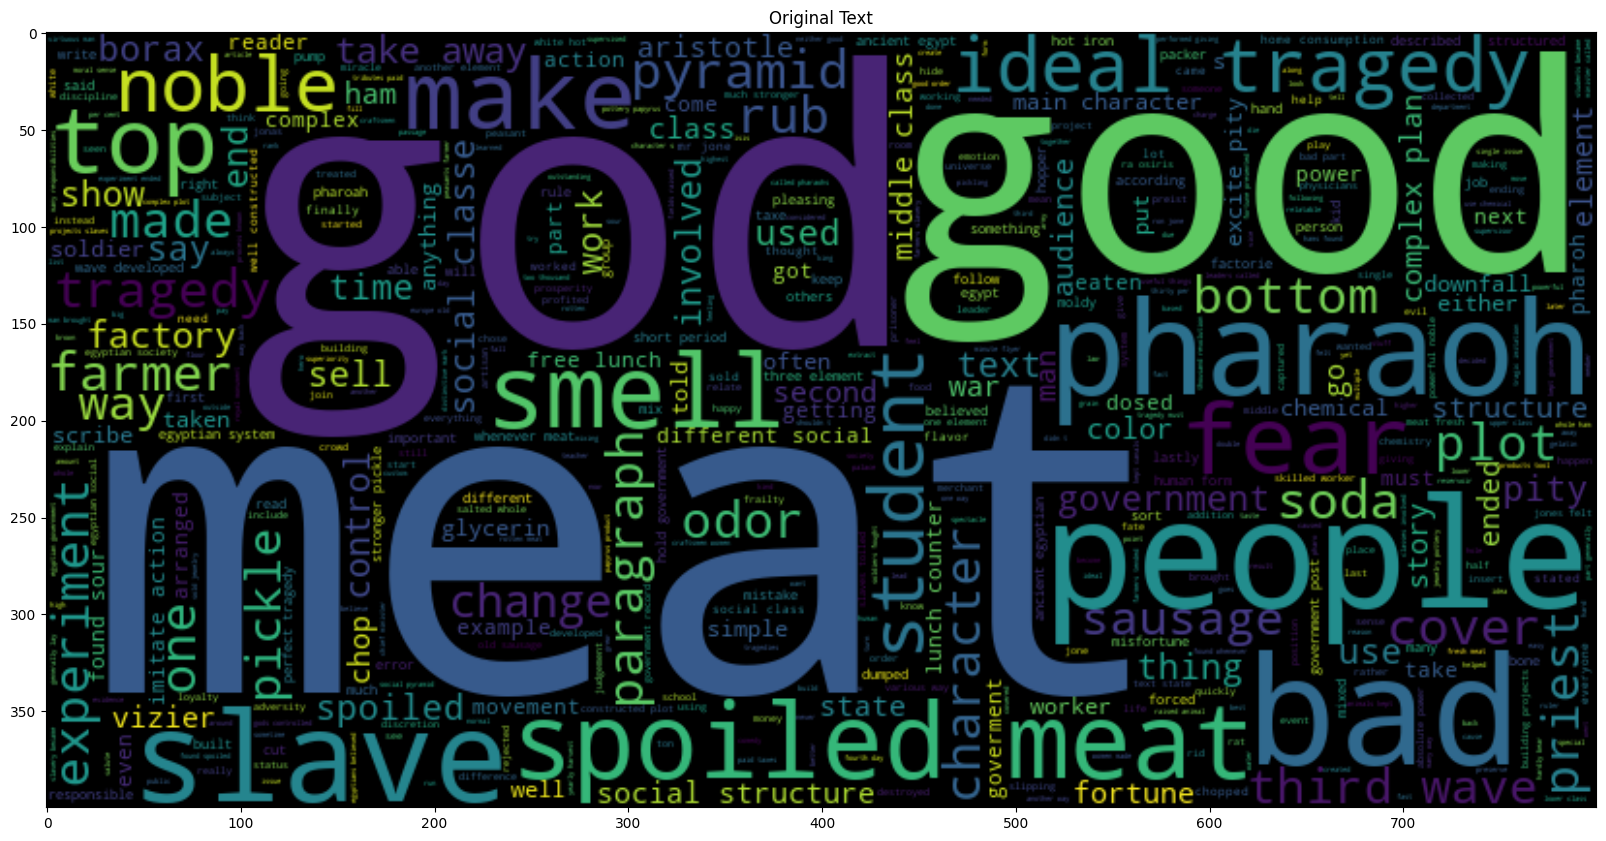

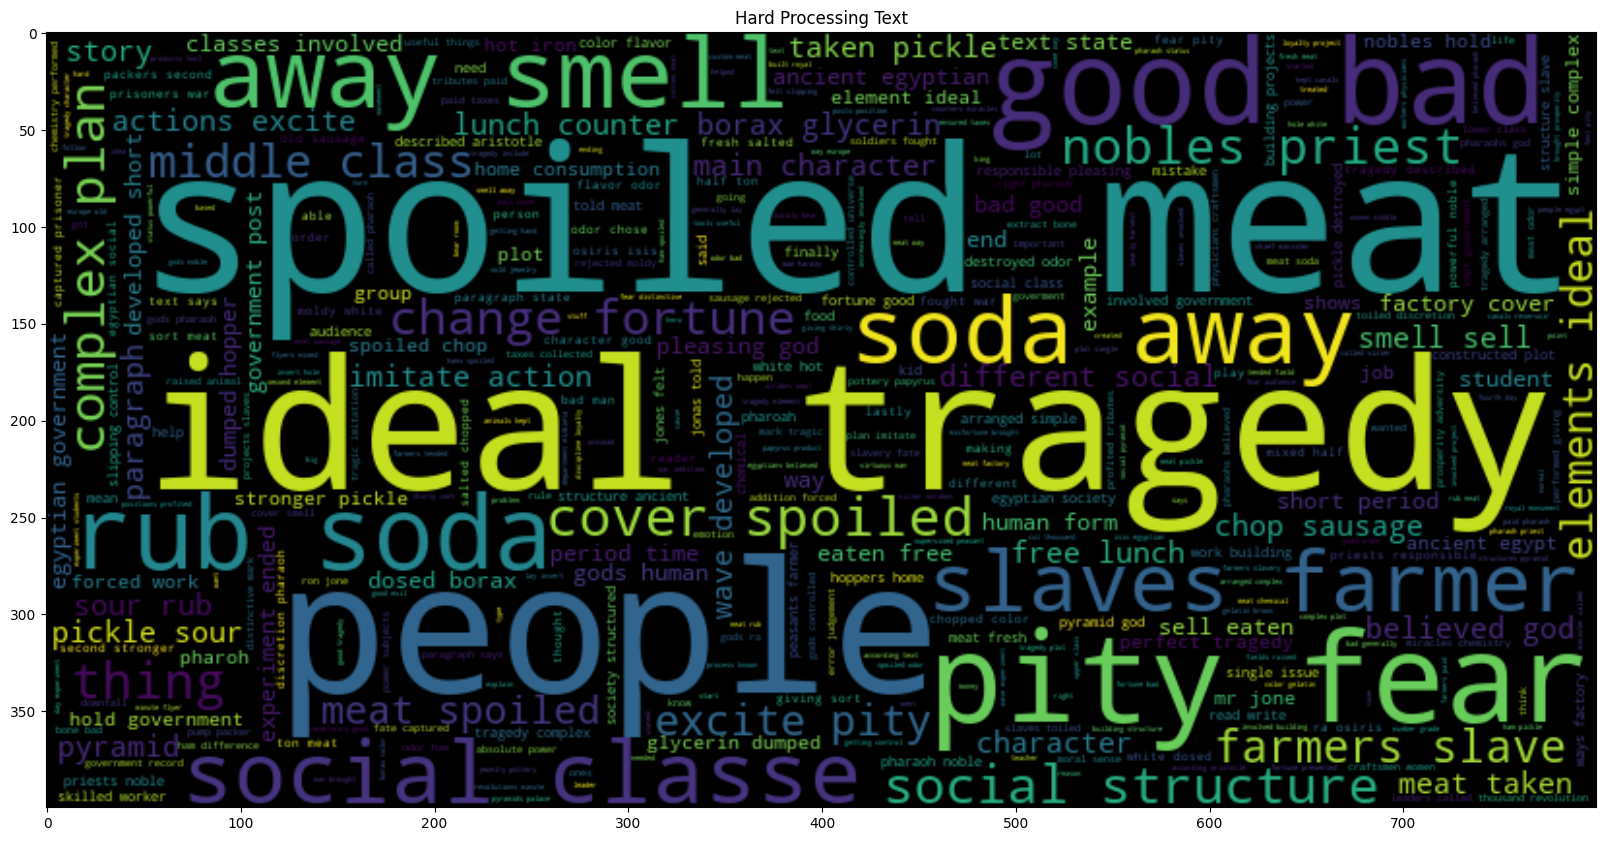

In [253]:
plt.figure(figsize = (20, 20)) 
plt.title("Original Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(summaries_train['text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20, 20)) 
plt.title("Hard Processing Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(summaries_train['text_without_stopwords']))
plt.imshow(wc, interpolation = 'bilinear')

In [254]:
summaries_train['prompt_merged_text'] = summaries_train['prompt_title'] + '\n' + summaries_train['prompt_question'] + '\n' + summaries_train['prompt_text']
summaries_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,stopwords,punctuation,text_without_stopwords,count_t,count_p,length_symbols,count_tp,mean_word_length,prompt_merged_text
0,000e8c3c7ddb,814d6b,the third wave was an experimentto see how peo...,0.205683,0.380538,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,25,3,wave experimentto people reacted new leader go...,31,282,224,0.109929,6.258065,wave\nsummarize wave developed short period ti...
1,0095993991fe,814d6b,the third wave only started as an experiment w...,0.205683,0.380538,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,27,5,wave started experiment class slowly spread ki...,27,282,194,0.095745,6.222222,wave\nsummarize wave developed short period ti...
2,00c20c6ddd23,814d6b,the experimen was orginally about how even whe...,0.567975,0.969062,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,35,8,experimen orginally terrible thngs happening f...,32,282,248,0.113475,6.781250,wave\nsummarize wave developed short period ti...
3,00d40ad10dc9,814d6b,the third wave developed so quickly due to the...,-0.910596,-0.081769,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,12,2,wave developed quickly students particip thos ...,13,282,90,0.046099,6.000000,wave\nsummarize wave developed short period ti...
4,014e2395b3c4,814d6b,the thrid wave movement in the school has more...,1.376083,2.389443,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,67,5,thrid wave movement school students join perio...,51,282,404,0.180851,6.941176,wave\nsummarize wave developed short period ti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6947,fef3e85236e5,39c16e,it has to be made on a complex storyline with...,-0.981265,-1.548900,summarize elements ideal tragedy described ari...,tragedy,chapter sequel said proceed consider poet aim ...,16,1,complex storyline plot makes audience feel pit...,15,236,109,0.063559,6.333333,tragedy\nsummarize elements ideal tragedy desc...
6948,ff0f65eecf02,39c16e,aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,summarize elements ideal tragedy described ari...,tragedy,chapter sequel said proceed consider poet aim ...,15,3,aristotle descirbes ideal tradgedy complex pla...,12,236,87,0.050847,6.333333,tragedy\nsummarize elements ideal tragedy desc...
6949,ff186473ea0a,39c16e,a tragedy should have a complex plan not a sim...,-0.834946,-0.593749,summarize elements ideal tragedy described ari...,tragedy,chapter sequel said proceed consider poet aim ...,16,3,tragedy complex plan simple good plot plot exc...,10,236,59,0.042373,5.000000,tragedy\nsummarize elements ideal tragedy desc...
6950,ff5e9e6068da,39c16e,aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,summarize elements ideal tragedy described ari...,tragedy,chapter sequel said proceed consider poet aim ...,22,4,aristotle believed ideal tradegy include purga...,27,236,201,0.114407,6.481481,tragedy\nsummarize elements ideal tragedy desc...


# Modeling

In [255]:
warnings.filterwarnings("ignore")

**I decided to leave my old code here in case I need it in the future.**

In [256]:
'''models = {
    'linear_regression': Pipeline([  
        ('classifier', LinearRegression())
    ]),
    'SVR': Pipeline([  
        ('classifier', SVR())
    ]),
    'gradient_boosting': Pipeline([  
        ('classifier', GradientBoostingRegressor(n_estimators = 100, max_depth = 7, loss='huber', learning_rate= 0.1, min_samples_split = 10, min_samples_leaf=10, subsample = 0.8))
    ])
}'''

"models = {\n    'linear_regression': Pipeline([  \n        ('classifier', LinearRegression())\n    ]),\n    'SVR': Pipeline([  \n        ('classifier', SVR())\n    ]),\n    'gradient_boosting': Pipeline([  \n        ('classifier', GradientBoostingRegressor(n_estimators = 100, max_depth = 7, loss='huber', learning_rate= 0.1, min_samples_split = 10, min_samples_leaf=10, subsample = 0.8))\n    ])\n}"

In [257]:
'''results = []

for model_name, model in models.items():
    scores = []
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    dummy_labels = np.zeros(len(summaries_train))
    
    for train_ind, test_ind in cv.split(summaries_train, dummy_labels):
        reviews_train = summaries_train.iloc[train_ind]
        reviews_test = summaries_train.iloc[test_ind]
        
        scaler = RobustScaler()

        y_train_content = scaler.fit_transform(reviews_train[['content']])
        y_test_content = scaler.transform(reviews_test[['content']])

        y_train_wording = scaler.fit_transform(reviews_train[['wording']])
        y_test_wording = scaler.transform(reviews_test[['wording']])
        
        transformer = SentenceTransformer('../input/sentence/all-MiniLM-L6-v2', device='cuda')
        
        reviews_train.reset_index(drop=True, inplace=True)
        reviews_test.reset_index(drop=True, inplace=True)

        prompt_text_embeddings_train = transformer.encode(reviews_train['prompt_merged_text'])
        clear_text_embeddings_train = transformer.encode(reviews_train['text_without_stopwords'])
        prompt_text_embeddings_test = transformer.encode(reviews_test['prompt_merged_text'])
        clear_text_embeddings_test = transformer.encode(reviews_test['text_without_stopwords'])
        
        for i, prompt_id in enumerate(reviews_train['prompt_id'].unique()):
            temp_sum = clear_text_embeddings_train[reviews_train[reviews_train['prompt_id'] == prompt_id].index]
            temp_tex = prompt_text_embeddings_train[i]
            reviews_train.loc[reviews_train['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
    
        for i, prompt_id in enumerate(reviews_test['prompt_id'].unique()):
            temp_sum = clear_text_embeddings_test[reviews_test[reviews_test['prompt_id'] == prompt_id].index]
            temp_tex = prompt_text_embeddings_test[i]
            reviews_test.loc[reviews_test['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
            
            
        reviews_train.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.fit_transform(reviews_train[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])

        reviews_test.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.transform(reviews_test[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])
      
        vectorizer = TfidfVectorizer(analyzer = 'word', lowercase=True)
        
        train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

        test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

        X_train = sparse.hstack((
                    train_summaries_vectors,
                    sparse.coo_matrix(reviews_train[['mean_word_length','count_p', 'stopwords', 'punctuation', 'tex_score']].to_numpy())
                ))
        X_test = sparse.hstack((
                    test_summaries_vectors,
                    sparse.coo_matrix(reviews_test[['mean_word_length','count_p','stopwords', 'punctuation', 'tex_score']].to_numpy())
                ))
    
        model_c = copy.deepcopy(model)
        model_c.fit(X_train, y_train_content)
        prediction_test_content = model_c.predict(X_test)
        
        
        train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

        test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

        X_train = sparse.hstack((
                    train_summaries_vectors,
                    sparse.coo_matrix(reviews_train[['mean_word_length']].to_numpy())
                ))
        
        X_test = sparse.hstack((
            test_summaries_vectors,
            sparse.coo_matrix(reviews_test[['mean_word_length']].to_numpy())
        ))
        
        model_w = copy.deepcopy(model)
        model_w.fit(X_train, y_train_wording)        
        prediction_test_wording = model_w.predict(X_test)
        
        rmse_c = np.sqrt(mean_squared_error(prediction_test_content, y_test_content))
        rmse_w = np.sqrt(mean_squared_error(prediction_test_wording, y_test_wording))
        scores.append((rmse_c + rmse_w) / 2)
        
    scores = np.array(scores)
    avg_score = round(scores.mean(), 4)
    std_score = round(scores.std(), 4)
    min_score = round(scores.min(), 4)
    max_score = round(scores.max(), 4)
    score_lower_bound = round(avg_score - 3*std_score, 4)
    score_higher_bound = round(avg_score + 3*std_score, 4)
    
    results.append({
        'experiment': model_name,
        'mcrmse_avg': avg_score,
        'mcrmse_std': std_score,
        'mcrmse_min': min_score,
        'mcrmse_max': max_score,
        'mcrmse_lower_bound_estimation': score_lower_bound,
        'mcrmse_higher_bound_estimation': score_higher_bound
    })
    
results = pd.DataFrame(results).sort_values('mcrmse_avg')
results'''

'results = []\n\nfor model_name, model in models.items():\n    scores = []\n    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)\n    dummy_labels = np.zeros(len(summaries_train))\n    \n    for train_ind, test_ind in cv.split(summaries_train, dummy_labels):\n        reviews_train = summaries_train.iloc[train_ind]\n        reviews_test = summaries_train.iloc[test_ind]\n        \n        scaler = RobustScaler()\n\n        y_train_content = scaler.fit_transform(reviews_train[[\'content\']])\n        y_test_content = scaler.transform(reviews_test[[\'content\']])\n\n        y_train_wording = scaler.fit_transform(reviews_train[[\'wording\']])\n        y_test_wording = scaler.transform(reviews_test[[\'wording\']])\n        \n        transformer = SentenceTransformer(\'../input/sentence/all-MiniLM-L6-v2\', device=\'cuda\')\n        \n        reviews_train.reset_index(drop=True, inplace=True)\n        reviews_test.reset_index(drop=True, inplace=True)\n\n        prompt_text

In [258]:
'''results = []

for model_name, model in models.items():
    scores = []
    group_kfold  = GroupKFold(n_splits = 4)
    dummy_labels = np.zeros(len(summaries_train))
    
    for train_ind, test_ind in group_kfold.split(summaries_train, dummy_labels, groups = summaries_train.prompt_id):
        reviews_train = summaries_train.iloc[train_ind]
        reviews_test = summaries_train.iloc[test_ind]
        scaler = RobustScaler()

        y_train_content = scaler.fit_transform(reviews_train[['content']])
        y_test_content = scaler.transform(reviews_test[['content']])

        y_train_wording = scaler.fit_transform(reviews_train[['wording']])
        y_test_wording = scaler.transform(reviews_test[['wording']])
        
        transformer = SentenceTransformer('../input/sentence/all-MiniLM-L6-v2', device='cuda')
        
        reviews_train.reset_index(drop=True, inplace=True)
        reviews_test.reset_index(drop=True, inplace=True)

        prompt_text_embeddings_train = transformer.encode(reviews_train['prompt_merged_text'])
        clear_text_embeddings_train = transformer.encode(reviews_train['text_without_stopwords'])
        prompt_text_embeddings_test = transformer.encode(reviews_test['prompt_merged_text'])
        clear_text_embeddings_test = transformer.encode(reviews_test['text_without_stopwords'])
        
        for i, prompt_id in enumerate(reviews_train['prompt_id'].unique()):
            temp_sum = clear_text_embeddings_train[reviews_train[reviews_train['prompt_id'] == prompt_id].index]
            temp_tex = prompt_text_embeddings_train[i]
            reviews_train.loc[reviews_train['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
    
        for i, prompt_id in enumerate(reviews_test['prompt_id'].unique()):
            temp_sum = clear_text_embeddings_test[reviews_test[reviews_test['prompt_id'] == prompt_id].index]
            temp_tex = prompt_text_embeddings_test[i]
            reviews_test.loc[reviews_test['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
            
            
        reviews_train.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.fit_transform(reviews_train[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])

        reviews_test.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.transform(reviews_test[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])
      
        vectorizer = TfidfVectorizer(analyzer = 'word', lowercase=True)
        
        train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

        test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

        X_train = sparse.hstack((
                    train_summaries_vectors,
                    sparse.coo_matrix(reviews_train[['mean_word_length','count_p', 'stopwords', 'punctuation', 'tex_score']].to_numpy())
                ))
        X_test = sparse.hstack((
                    test_summaries_vectors,
                    sparse.coo_matrix(reviews_test[['mean_word_length','count_p','stopwords', 'punctuation', 'tex_score']].to_numpy())
                ))
    
        model_c = copy.deepcopy(model)
        model_c.fit(X_train, y_train_content)
        prediction_test_content = model_c.predict(X_test)
        
        
        train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

        test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

        X_train = sparse.hstack((
                    train_summaries_vectors,
                    sparse.coo_matrix(reviews_train[['mean_word_length']].to_numpy())
                ))
        
        X_test = sparse.hstack((
            test_summaries_vectors,
            sparse.coo_matrix(reviews_test[['mean_word_length']].to_numpy())
        ))
        
        model_w = copy.deepcopy(model)
        model_w.fit(X_train, y_train_wording)        
        prediction_test_wording = model_w.predict(X_test)
        
        rmse_c = np.sqrt(mean_squared_error(prediction_test_content, y_test_content))
        rmse_w = np.sqrt(mean_squared_error(prediction_test_wording, y_test_wording))
        scores.append((rmse_c + rmse_w) / 2)
        
    scores = np.array(scores)
    avg_score = round(scores.mean(), 4)
    std_score = round(scores.std(), 4)
    min_score = round(scores.min(), 4)
    max_score = round(scores.max(), 4)
    score_lower_bound = round(avg_score - 3*std_score, 4)
    score_higher_bound = round(avg_score + 3*std_score, 4)
    
    results.append({
        'experiment': model_name,
        'mcrmse_avg': avg_score,
        'mcrmse_std': std_score,
        'mcrmse_min': min_score,
        'mcrmse_max': max_score,
        'mcrmse_lower_bound_estimation': score_lower_bound,
        'mcrmse_higher_bound_estimation': score_higher_bound
    })
    
results = pd.DataFrame(results).sort_values('mcrmse_avg')
results'''

'results = []\n\nfor model_name, model in models.items():\n    scores = []\n    group_kfold  = GroupKFold(n_splits = 4)\n    dummy_labels = np.zeros(len(summaries_train))\n    \n    for train_ind, test_ind in group_kfold.split(summaries_train, dummy_labels, groups = summaries_train.prompt_id):\n        reviews_train = summaries_train.iloc[train_ind]\n        reviews_test = summaries_train.iloc[test_ind]\n        scaler = RobustScaler()\n\n        y_train_content = scaler.fit_transform(reviews_train[[\'content\']])\n        y_test_content = scaler.transform(reviews_test[[\'content\']])\n\n        y_train_wording = scaler.fit_transform(reviews_train[[\'wording\']])\n        y_test_wording = scaler.transform(reviews_test[[\'wording\']])\n        \n        transformer = SentenceTransformer(\'../input/sentence/all-MiniLM-L6-v2\', device=\'cuda\')\n        \n        reviews_train.reset_index(drop=True, inplace=True)\n        reviews_test.reset_index(drop=True, inplace=True)\n\n        prompt

In [259]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
os.environ["CUDA_LAUNCH_BLOCKING"]='1'
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [260]:
torch.backends.cuda.deterministic = True

if torch.cuda.is_available():
    global_device = "cuda"
else:
    global_device = "cpu"
print("Training device:", global_device)

Training device: cuda


In [261]:
#from gensim.models import Word2Vec

In [262]:
reviews_train = summaries_train[summaries_train.prompt_id != '3b9047']
reviews_test = summaries_train[summaries_train.prompt_id == '3b9047']

In [263]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(reviews_train["text_without_stopwords"]), 
    specials=["<unk>", "<pad>"]
)
vocab.set_default_index(vocab["<unk>"])

In [264]:
#training_corpus = reviews_train.text_without_stopwords.apply(lambda x: x.split(" "))
#model = Word2Vec(sentences=training_corpus, vector_size=128)

In [265]:
#sentence_length = reviews_train.text_without_stopwords.apply(lambda x: x.split(" ")).apply(len).max()
#word_map = {word:idx for idx,word in enumerate(model.wv.key_to_index, start=2)}
#training_sentence_data = (reviews_train.text_without_stopwords.apply(lambda x: list(map(lambda word: word_map[word] if word in word_map else 1, x.split(" ")))))
#sentence_length=600
#training_sentence_data = (list(map(lambda x: np.pad(x, (0, sentence_length-len(x))), training_sentence_data)))
#training_sentence_data = (list(map(lambda x: torch.LongTensor(x), training_sentence_data)))
#word_vectors_for_training = np.insert(model.wv.vectors, 0, np.random.uniform(model.wv.vectors.min(),model.wv.vectors.max(), 128), axis=0)
#word_vectors_for_training = np.insert(word_vectors_for_training,   0, np.zeros(128),axis=0)
#word_vectors_for_training = torch.FloatTensor(word_vectors_for_training)

**I tried to use Word2Vec instead of trainable embeddings, but every time I have problems with pre-trainable weights, because the moment I run the train model, I get an error that the two matrices cannot be multiplied due to different sizes . If you can help me with this, I will be glad.
"mat1 and mat2 shapes cannot be multiplied (1x32 and 256x1)"**

In [266]:
class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None,
        dropout_rate=0.4
    ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
        # TODO: What is bidirectional ? Try unidirectional
        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(
                rnn_channels * 2 if bidirectional else rnn_channels, 
                out_channels, 
            )
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimension reminder : [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x

In [267]:
vocab_with_freq = pd.Series(list(chain(*list(yield_tokens(reviews_train["text_without_stopwords"]))))).value_counts()
vocab_with_freq

meat         5038
tragedy      2824
spoiled      2267
bad          2164
good         2028
             ... 
formerluy       1
dish            1
usefull         1
spoilet         1
circle          1
Name: count, Length: 8144, dtype: int64

In [268]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        pad_token_id=1,
        trim_policy="random"
    ):
        self.targets = targets
        self.texts = texts 
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        self.pad_token_id = pad_token_id
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    def select_text_subsequence(self, input):
        if len(input) < self.max_length:
            return input + [self.pad_token_id] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.tokenizer(self.texts[idx]))
        # In order to form batch, which is a tensor - we have to get sequnces of same length
        text_ids = self.select_text_subsequence(text_ids)
        text_target = self.targets[idx]
        # Why did I do so ???
        if not isinstance(text_target, (list, np.ndarray)):
            text_target = np.array([text_target])
        return (
            torch.LongTensor(text_ids), 
            torch.from_numpy(text_target).float()
        )
    
    def __len__(self):
        return len(self.texts)

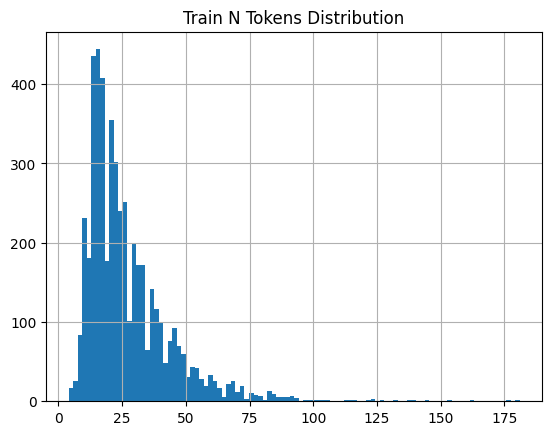

0.99 Quantile of N tokens: 87.03999999999996


In [269]:
train_n_tokens = reviews_train["text_without_stopwords"].apply(lambda x : len(tokenizer(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.99 Quantile of N tokens: {np.quantile(train_n_tokens, 0.99)}")

In [270]:
SEQ_LEN = 87

In [271]:
'''model = SentenceTransformer('../input/sentence/all-MiniLM-L6-v2', device='cuda')'''

"model = SentenceTransformer('../input/sentence/all-MiniLM-L6-v2', device='cuda')"

In [272]:
'''reviews_train.reset_index(drop=True, inplace=True)
reviews_test.reset_index(drop=True, inplace=True)'''

'reviews_train.reset_index(drop=True, inplace=True)\nreviews_test.reset_index(drop=True, inplace=True)'

In [273]:
'''prompt_text_embeddings_train = model.encode(reviews_train['prompt_merged_text'])
clear_text_embeddings_train = model.encode(reviews_train['text_without_stopwords'])
prompt_text_embeddings_test = model.encode(reviews_test['prompt_merged_text'])
clear_text_embeddings_test = model.encode(reviews_test['text_without_stopwords'])'''

"prompt_text_embeddings_train = model.encode(reviews_train['prompt_merged_text'])\nclear_text_embeddings_train = model.encode(reviews_train['text_without_stopwords'])\nprompt_text_embeddings_test = model.encode(reviews_test['prompt_merged_text'])\nclear_text_embeddings_test = model.encode(reviews_test['text_without_stopwords'])"

In [274]:
'''for i, prompt_id in enumerate(reviews_train['prompt_id'].unique()):
    temp_sum = clear_text_embeddings_train[reviews_train[reviews_train['prompt_id'] == prompt_id].index]
    temp_tex = prompt_text_embeddings_train[i]
    reviews_train.loc[reviews_train['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
    
for i, prompt_id in enumerate(reviews_test['prompt_id'].unique()):
    temp_sum = clear_text_embeddings_test[reviews_test[reviews_test['prompt_id'] == prompt_id].index]
    temp_tex = prompt_text_embeddings_test[i]
    reviews_test.loc[reviews_test['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))'''

'for i, prompt_id in enumerate(reviews_train[\'prompt_id\'].unique()):\n    temp_sum = clear_text_embeddings_train[reviews_train[reviews_train[\'prompt_id\'] == prompt_id].index]\n    temp_tex = prompt_text_embeddings_train[i]\n    reviews_train.loc[reviews_train[\'prompt_id\'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))\n    \nfor i, prompt_id in enumerate(reviews_test[\'prompt_id\'].unique()):\n    temp_sum = clear_text_embeddings_test[reviews_test[reviews_test[\'prompt_id\'] == prompt_id].index]\n    temp_tex = prompt_text_embeddings_test[i]\n    reviews_test.loc[reviews_test[\'prompt_id\'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))'

In [275]:
#reviews_train.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation']] = scaler.fit_transform(reviews_train[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation']])

#reviews_test.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation']] = scaler.transform(reviews_test[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation']])

In [276]:
#reviews_train[['content', 'wording', 'tex_score']].corr()

In [277]:
train_torch_dataset = TextDataset(
    texts=reviews_train["text_without_stopwords"].to_list(),
    targets=reviews_train["content"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    # trim_policy="first"
)

In [278]:
doc_idx = 10

doc_ids, doc_target = train_torch_dataset[doc_idx]
print(
    f"Text: {train_torch_dataset.texts[doc_idx]}\n"
    f"Text Ids: {doc_ids}\n"
    f"Target: {doc_target}\n"
    f"Text Ids length: {len(doc_ids)}"
)

Text: wave started students join group mr jones decided terminate movement getting contro
Text Ids: tensor([  25,   81,    8,  149,  142,  128,   21,  216,  636,   66,   91, 1999,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1])
Target: tensor([-1.2692])
Text Ids length: 87


In [279]:
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

for batch in train_torch_dataloader:
    break
    
print(
    f"`Text` batch:\n{batch[0]}\n"
    f"`Target` batch:\n{batch[1]}"
)

`Text` batch:
tensor([[ 24, 212,  32,  ...,   1,   1,   1],
        [  9,   3,  87,  ...,   1,   1,   1],
        [ 32,   9,   3,  ...,   1,   1,   1],
        ...,
        [ 25,  45,  68,  ...,   1,   1,   1],
        [ 17, 136,   4,  ...,   1,   1,   1],
        [323,  24, 212,  ...,   1,   1,   1]])
`Target` batch:
tensor([[-0.2106],
        [-0.8313],
        [ 1.0019],
        [ 0.2970],
        [-0.1852],
        [ 1.4078],
        [-1.2642],
        [-0.6818],
        [-0.2854],
        [ 2.1095],
        [-0.9813],
        [ 2.1135],
        [-1.0656],
        [-0.3933],
        [ 0.6593],
        [ 0.3764]])


In [280]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cpu"
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []
    # We need this context in order to control gradient computation
    # mode == True - gradient will NOT be computed, mode == False - gradient will be computed
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            # 1.1 Compute Forward path
            predicted_label = inp_model(text)
            # 1.2 Compute Cost function (part of Forward path)
            loss = criterion(predicted_label, label)
            if mode == "train":
                # 2. Compute Backward path
                loss.mean().backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                # 3. Apply gradient descent `on steroids` 
                optimizer.step()
                
            # Accumulate stats
            # We receive logits and we have to transform them into `probs`. That is why sigmoid is used
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())
    all_predicted_label = np.concatenate(all_predicted_label)
    all_losses = np.concatenate(all_losses)
    all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets

In [281]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    rnn_channels=256,
    out_channels=1,
    average_type="mean",
    bidirectional=True
).to(global_device)

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [282]:
train_torch_dataset = TextDataset(
    texts=reviews_train["text_without_stopwords"].to_list(),
    targets=reviews_train["content"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
)
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    # It is highly important to shuffle data while training. Why ?
    shuffle=True,
    # It is important to drop last batch while training. Why ?
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=reviews_test["text_without_stopwords"].to_list(),
    targets=reviews_test["content"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

In [283]:
def comp_metric(y_true, y_pred, tresh=None):
    assert y_true.shape == y_pred.shape
    if tresh is not None:
        y_pred = y_pred > tresh
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [284]:
n_epochs = 20

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_metrics = []
train_metrics = []

best_metric = - np.inf
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="train"
    )
    # 1.2 Compute and print train metrics
    train_metric = comp_metric(
        train_epoch_targets, 
        train_epoch_labels
    )
    print("Train metric:", train_metric)
    print("Train BCE loss:", train_epoch_losses.mean())
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    valid_metric = comp_metric(
        valid_epoch_targets, 
        valid_epoch_labels
    )
    print("Valid metric:", valid_metric)
    print("Valid BCE loss:", valid_epoch_losses.mean())
    # 3. Update learning rate (if needed)
    scheduler.step(valid_metric)
    # 4. Save best model
    if valid_metric > best_metric:
        best_metric = valid_metric
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats  
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_metrics.append(valid_metric)
    train_metrics.append(train_metric)

Starting Epoch 1
Train phase


100%|██████████| 156/156 [00:03<00:00, 39.96it/s]


Train metric: 0.8269259
Train BCE loss: -13.588316
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.44it/s]


Valid metric: 0.8919586
Valid BCE loss: -25.642643
Starting Epoch 2
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.43it/s]


Train metric: 0.80352104
Train BCE loss: -39.817707
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.60it/s]


Valid metric: 0.85454994
Valid BCE loss: -47.60418
Epoch 00002: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 3
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.56it/s]


Train metric: 0.7746614
Train BCE loss: -64.02738
Valid phase


100%|██████████| 62/62 [00:01<00:00, 56.99it/s]


Valid metric: 0.8530055
Valid BCE loss: -65.77493
Epoch 00003: reducing learning rate of group 0 to 2.5000e-04.
Starting Epoch 4
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.32it/s]


Train metric: 0.78523946
Train BCE loss: -75.36849
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.53it/s]


Valid metric: 0.8599006
Valid BCE loss: -70.275604
Epoch 00004: reducing learning rate of group 0 to 1.2500e-04.
Starting Epoch 5
Train phase


100%|██████████| 156/156 [00:03<00:00, 40.93it/s]


Train metric: 0.77181095
Train BCE loss: -83.16824
Valid phase


100%|██████████| 62/62 [00:01<00:00, 58.01it/s]


Valid metric: 0.85934573
Valid BCE loss: -76.73579
Epoch 00005: reducing learning rate of group 0 to 6.2500e-05.
Starting Epoch 6
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.51it/s]


Train metric: 0.76632816
Train BCE loss: -87.28386
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.39it/s]


Valid metric: 0.85736054
Valid BCE loss: -79.08987
Epoch 00006: reducing learning rate of group 0 to 3.1250e-05.
Starting Epoch 7
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.29it/s]


Train metric: 0.76549643
Train BCE loss: -89.15839
Valid phase


100%|██████████| 62/62 [00:01<00:00, 51.62it/s]


Valid metric: 0.8606856
Valid BCE loss: -79.53713
Epoch 00007: reducing learning rate of group 0 to 1.5625e-05.
Starting Epoch 8
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.41it/s]


Train metric: 0.76493233
Train BCE loss: -90.17815
Valid phase


100%|██████████| 62/62 [00:01<00:00, 58.13it/s]


Valid metric: 0.86064565
Valid BCE loss: -79.79607
Epoch 00008: reducing learning rate of group 0 to 7.8125e-06.
Starting Epoch 9
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.63it/s]


Train metric: 0.76441914
Train BCE loss: -90.56109
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.01it/s]


Valid metric: 0.8618425
Valid BCE loss: -79.85773
Epoch 00009: reducing learning rate of group 0 to 3.9063e-06.
Starting Epoch 10
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.47it/s]


Train metric: 0.7652586
Train BCE loss: -90.696724
Valid phase


100%|██████████| 62/62 [00:01<00:00, 58.31it/s]


Valid metric: 0.8617445
Valid BCE loss: -79.9759
Epoch 00010: reducing learning rate of group 0 to 1.9531e-06.
Starting Epoch 11
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.35it/s]


Train metric: 0.76579416
Train BCE loss: -90.80068
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.46it/s]


Valid metric: 0.86181444
Valid BCE loss: -80.01846
Epoch 00011: reducing learning rate of group 0 to 9.7656e-07.
Starting Epoch 12
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.50it/s]


Train metric: 0.7640506
Train BCE loss: -90.832535
Valid phase


100%|██████████| 62/62 [00:01<00:00, 58.61it/s]


Valid metric: 0.86183786
Valid BCE loss: -80.043655
Epoch 00012: reducing learning rate of group 0 to 4.8828e-07.
Starting Epoch 13
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.53it/s]


Train metric: 0.76561075
Train BCE loss: -90.84303
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.33it/s]


Valid metric: 0.8618976
Valid BCE loss: -80.048965
Epoch 00013: reducing learning rate of group 0 to 2.4414e-07.
Starting Epoch 14
Train phase


100%|██████████| 156/156 [00:03<00:00, 40.50it/s]


Train metric: 0.76639074
Train BCE loss: -90.74468
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.94it/s]


Valid metric: 0.8618938
Valid BCE loss: -80.056046
Epoch 00014: reducing learning rate of group 0 to 1.2207e-07.
Starting Epoch 15
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.57it/s]


Train metric: 0.76588446
Train BCE loss: -91.01861
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.85it/s]


Valid metric: 0.86189836
Valid BCE loss: -80.05865
Epoch 00015: reducing learning rate of group 0 to 1.0000e-07.
Starting Epoch 16
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.04it/s]


Train metric: 0.765162
Train BCE loss: -90.89596
Valid phase


100%|██████████| 62/62 [00:01<00:00, 56.37it/s]


Valid metric: 0.8618962
Valid BCE loss: -80.06148
Starting Epoch 17
Train phase


100%|██████████| 156/156 [00:03<00:00, 40.72it/s]


Train metric: 0.7648015
Train BCE loss: -91.02258
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.88it/s]


Valid metric: 0.86190486
Valid BCE loss: -80.062935
Starting Epoch 18
Train phase


100%|██████████| 156/156 [00:03<00:00, 39.80it/s]


Train metric: 0.7638438
Train BCE loss: -90.96025
Valid phase


100%|██████████| 62/62 [00:01<00:00, 58.36it/s]


Valid metric: 0.8619226
Valid BCE loss: -80.06325
Starting Epoch 19
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.35it/s]


Train metric: 0.7641846
Train BCE loss: -91.222496
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.97it/s]


Valid metric: 0.86192226
Valid BCE loss: -80.06597
Starting Epoch 20
Train phase


100%|██████████| 156/156 [00:03<00:00, 40.23it/s]


Train metric: 0.7651128
Train BCE loss: -90.88212
Valid phase


100%|██████████| 62/62 [00:01<00:00, 56.33it/s]

Valid metric: 0.8619006
Valid BCE loss: -80.071175


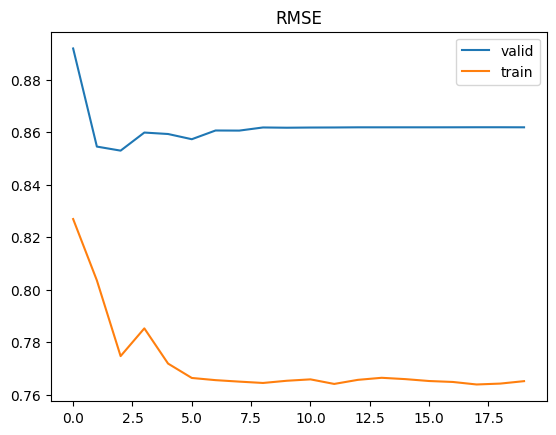

In [285]:
plt.title("RMSE")
plt.plot(valid_metrics, label="valid")
plt.plot(train_metrics, label="train")
plt.legend()
plt.show()

In [286]:
nn_model.load_state_dict(best_model_state_dict)

test_torch_dataset = TextDataset(
    texts=reviews_test["text_without_stopwords"].to_list(),
    targets=reviews_test["content"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device=global_device,
    mode="eval"
)

100%|██████████| 62/62 [00:01<00:00, 57.50it/s]


In [287]:
valid_metric_c= comp_metric(
        test_targets, 
        test_labels
    )
print(valid_metric_c)

0.8919586


In [288]:
train_torch_dataset = TextDataset(
    texts=reviews_test["text_without_stopwords"].to_list(),
    targets=reviews_train["wording"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    # trim_policy="first"
)

In [289]:
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

In [290]:
nn_model_w = UniversalRNN(
    num_embeddings=len(vocab),
    rnn_channels=256,
    out_channels=1,
    average_type="mean",
    bidirectional=True
).to(global_device)

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [291]:
train_torch_dataset = TextDataset(
    texts=reviews_train["text_without_stopwords"].to_list(),
    targets=reviews_train["wording"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
)
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    # It is highly important to shuffle data while training. Why ?
    shuffle=True,
    # It is important to drop last batch while training. Why ?
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=reviews_test["text_without_stopwords"].to_list(),
    targets=reviews_test["wording"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

In [294]:
n_epochs = 10

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_metrics = []
train_metrics = []

best_metric = - np.inf
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="train"
    )
    # 1.2 Compute and print train metrics
    train_metric = comp_metric(
        train_epoch_targets, 
        train_epoch_labels,
        tresh=0.5
    )
    print("Train metric:", train_metric)
    print("Train BCE loss:", train_epoch_losses.mean())
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    valid_metric = comp_metric(
        valid_epoch_targets, 
        valid_epoch_labels,
        tresh=0.5
    )
    print("Valid metric:", valid_metric)
    print("Valid BCE loss:", valid_epoch_losses.mean())
    # 3. Update learning rate (if needed)
    scheduler.step(valid_metric)
    # 4. Save best model
    if valid_metric > best_metric:
        best_metric = valid_metric
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats  
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_metrics.append(valid_metric)
    train_metrics.append(train_metric)

Starting Epoch 1
Train phase


100%|██████████| 156/156 [00:03<00:00, 40.63it/s]


Train metric: 0.8802104
Train BCE loss: -93.903206
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.45it/s]


Valid metric: 0.950896
Valid BCE loss: -45.47735
Starting Epoch 2
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.24it/s]


Train metric: 0.8793878
Train BCE loss: -122.249596
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.87it/s]


Valid metric: 0.93979263
Valid BCE loss: -50.794098
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 3
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.33it/s]


Train metric: 0.8691371
Train BCE loss: -150.2323
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.87it/s]


Valid metric: 0.9314465
Valid BCE loss: -80.304985
Epoch 00005: reducing learning rate of group 0 to 2.5000e-04.
Starting Epoch 4
Train phase


100%|██████████| 156/156 [00:03<00:00, 40.57it/s]


Train metric: 0.8627783
Train BCE loss: -167.98602
Valid phase


100%|██████████| 62/62 [00:01<00:00, 52.91it/s]


Valid metric: 0.94961447
Valid BCE loss: -70.323555
Epoch 00006: reducing learning rate of group 0 to 1.2500e-04.
Starting Epoch 5
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.24it/s]


Train metric: 0.8642693
Train BCE loss: -176.78145
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.67it/s]


Valid metric: 0.94411194
Valid BCE loss: -74.59906
Epoch 00007: reducing learning rate of group 0 to 6.2500e-05.
Starting Epoch 6
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.43it/s]


Train metric: 0.86247873
Train BCE loss: -180.99605
Valid phase


100%|██████████| 62/62 [00:01<00:00, 56.67it/s]


Valid metric: 0.9429844
Valid BCE loss: -76.122826
Epoch 00008: reducing learning rate of group 0 to 3.1250e-05.
Starting Epoch 7
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.02it/s]


Train metric: 0.8609941
Train BCE loss: -183.31812
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.51it/s]


Valid metric: 0.94438004
Valid BCE loss: -76.23993
Epoch 00009: reducing learning rate of group 0 to 1.5625e-05.
Starting Epoch 8
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.40it/s]


Train metric: 0.86140156
Train BCE loss: -184.37953
Valid phase


100%|██████████| 62/62 [00:01<00:00, 58.04it/s]


Valid metric: 0.94388664
Valid BCE loss: -76.788216
Epoch 00010: reducing learning rate of group 0 to 7.8125e-06.
Starting Epoch 9
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.26it/s]


Train metric: 0.8623004
Train BCE loss: -185.00366
Valid phase


100%|██████████| 62/62 [00:01<00:00, 56.12it/s]


Valid metric: 0.94504476
Valid BCE loss: -76.6996
Epoch 00011: reducing learning rate of group 0 to 3.9063e-06.
Starting Epoch 10
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.15it/s]


Train metric: 0.86157024
Train BCE loss: -185.02008
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.59it/s]

Valid metric: 0.94171834
Valid BCE loss: -77.1634
Epoch 00012: reducing learning rate of group 0 to 1.9531e-06.


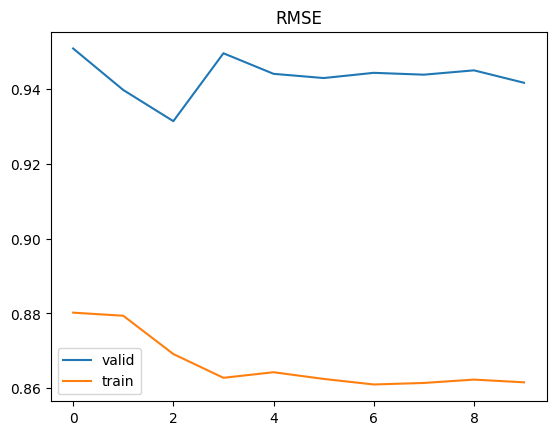

In [295]:
plt.title("RMSE")
plt.plot(valid_metrics, label="valid")
plt.plot(train_metrics, label="train")
plt.legend()
plt.show()

In [296]:
nn_model_w.load_state_dict(best_model_state_dict)

test_torch_dataset = TextDataset(
    texts=reviews_test["text_without_stopwords"].to_list(),
    targets=reviews_test["wording"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model_w,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device=global_device,
    mode="eval"
)

100%|██████████| 62/62 [00:01<00:00, 55.75it/s]


In [297]:
valid_metric_w = comp_metric(
        test_targets, 
        test_labels
    )
print(valid_metric_w) 

0.94947284


In [300]:
print((valid_metric_w+valid_metric_c)/2)

0.9207156896591187


In [303]:
results = []
scores = []
group_kfold  = GroupKFold(n_splits = 4)
dummy_labels = np.zeros(len(summaries_train))

for train_ind, test_ind in group_kfold.split(summaries_train, dummy_labels, groups = summaries_train.prompt_id):
    reviews_train = summaries_train.iloc[train_ind]
    reviews_test = summaries_train.iloc[test_ind]

    train_torch_dataset = TextDataset(
        texts=reviews_train["text_without_stopwords"].to_list(),
        targets=reviews_train["content"].values,
        dataset_vocab=vocab,
        dataset_tokenizer=tokenizer,
        max_length=SEQ_LEN,
        # trim_policy="first"
    )
    
    train_torch_dataloader = torch.utils.data.DataLoader(
        train_torch_dataset,
        batch_size=16,
        shuffle=True,
        drop_last=True,
        num_workers=8,
        pin_memory=True
    )
    
    nn_model = UniversalRNN(
        num_embeddings=len(vocab),
        rnn_channels=256,
        out_channels=1,
        average_type="mean",
        bidirectional=True
    ).to(global_device)
    
    train_torch_dataset = TextDataset(
        texts=reviews_train["text_without_stopwords"].to_list(),
        targets=reviews_train["content"].values,
        dataset_vocab=vocab,
        dataset_tokenizer=tokenizer,
        max_length=SEQ_LEN,
    )
    train_torch_dataloader = torch.utils.data.DataLoader(
        train_torch_dataset,
        batch_size=32,
        # It is highly important to shuffle data while training. Why ?
        shuffle=True,
        # It is important to drop last batch while training. Why ?
        drop_last=True,
        num_workers=8,
        pin_memory=True
    )

    valid_torch_dataset = TextDataset(
        texts=reviews_test["text_without_stopwords"].to_list(),
        targets=reviews_test["content"].values,
        dataset_vocab=vocab,
        dataset_tokenizer=tokenizer,
        max_length=SEQ_LEN,
        trim_policy="first"
    )
    valid_torch_dataloader = torch.utils.data.DataLoader(
        valid_torch_dataset,
        batch_size=32,
        shuffle=False,
        drop_last=False,
        num_workers=8,
        pin_memory=True
    )

    criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)
    
    
    n_epochs = 3

    train_all_epoch_labels = []
    train_all_epoch_losses = []
    train_all_epoch_targets = []
    valid_all_epoch_labels = []
    valid_all_epoch_losses = []
    valid_all_epoch_targets = []
    valid_metrics = []
    train_metrics = []

    best_metric = - np.inf
    best_model_state_dict = None

    for epoch in range(1, n_epochs + 1):
        print(f"Starting Epoch {epoch}")
        # 1.1 Iterate over all train dataset and update model weights
        print("Train phase")
        train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
            dataloader=train_torch_dataloader, 
            inp_model=nn_model,
            inp_optimizer=optimizer,
            inp_criterion=criterion,
            device=global_device,
            mode="train"
        )
        # 1.2 Compute and print train metrics
        train_metric = comp_metric(
            train_epoch_targets, 
            train_epoch_labels
        )
        print("Train metric:", train_metric)
        print("Train BCE loss:", train_epoch_losses.mean())
        # 2.1 Iterate over all valid dataset and compute predictions
        print("Valid phase")
        valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
            dataloader=valid_torch_dataloader, 
            inp_model=nn_model,
            inp_optimizer=optimizer,
            inp_criterion=criterion,
            device=global_device,
            mode="eval"
        )
        # 2.2 Compute and print valid metrics
        valid_metric = comp_metric(
            valid_epoch_targets, 
            valid_epoch_labels
        )
        print("Valid metric:", valid_metric)
        print("Valid BCE loss:", valid_epoch_losses.mean())
        # 3. Update learning rate (if needed)
        scheduler.step(valid_metric)
        # 4. Save best model
        if valid_metric > best_metric:
            best_metric = valid_metric
            best_model_state_dict = deepcopy(nn_model.state_dict())
        # 5. Accumulate all stats  
        train_all_epoch_labels.append(train_epoch_labels)
        train_all_epoch_losses.append(train_epoch_losses)
        train_all_epoch_targets.append(train_epoch_targets)
        valid_all_epoch_labels.append(valid_epoch_labels)
        valid_all_epoch_losses.append(valid_epoch_losses)
        valid_all_epoch_targets.append(valid_epoch_targets)
        valid_metrics.append(valid_metric)
        train_metrics.append(train_metric)
        
    nn_model.load_state_dict(best_model_state_dict)

    test_torch_dataset = TextDataset(
        texts=reviews_test["text_without_stopwords"].to_list(),
        targets=reviews_test["content"].values,
        dataset_vocab=vocab,
        dataset_tokenizer=tokenizer,
        max_length=SEQ_LEN,
        trim_policy="first"
    )
    test_torch_dataloader = torch.utils.data.DataLoader(
        test_torch_dataset,
        batch_size=32,
        shuffle=False,
        drop_last=False,
        num_workers=8,
        pin_memory=True
    )

    test_labels, test_losses, test_targets = torch_loop(
        dataloader=test_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="eval"
    )
    
    valid_metric_c= comp_metric(
        test_targets, 
        test_labels
    )
    print(valid_metric_c)
    
    train_torch_dataset = TextDataset(
        texts=reviews_test["text_without_stopwords"].to_list(),
        targets=reviews_train["wording"].values,
        dataset_vocab=vocab,
        dataset_tokenizer=tokenizer,
        max_length=SEQ_LEN,
        # trim_policy="first"
    )
    
    train_torch_dataloader = torch.utils.data.DataLoader(
        train_torch_dataset,
        batch_size=16,
        shuffle=True,
        drop_last=True,
        num_workers=8,
        pin_memory=True
    )
    
    nn_model_w = UniversalRNN(
        num_embeddings=len(vocab),
        rnn_channels=256,
        out_channels=1,
        average_type="mean",
        bidirectional=True
    ).to(global_device)
    
    train_torch_dataset = TextDataset(
        texts=reviews_train["text_without_stopwords"].to_list(),
        targets=reviews_train["wording"].values,
        dataset_vocab=vocab,
        dataset_tokenizer=tokenizer,
        max_length=SEQ_LEN,
        )
    train_torch_dataloader = torch.utils.data.DataLoader(
        train_torch_dataset,
        batch_size=32,
        # It is highly important to shuffle data while training. Why ?
        shuffle=True,
        # It is important to drop last batch while training. Why ?
        drop_last=True,
        num_workers=8,
        pin_memory=True
    )

    valid_torch_dataset = TextDataset(
        texts=reviews_test["text_without_stopwords"].to_list(),
        targets=reviews_test["wording"].values,
        dataset_vocab=vocab,
        dataset_tokenizer=tokenizer,
        max_length=SEQ_LEN,
        trim_policy="first"
    )
    valid_torch_dataloader = torch.utils.data.DataLoader(
        valid_torch_dataset,
        batch_size=32,
        shuffle=False,
        drop_last=False,
        num_workers=8,
        pin_memory=True
    )

    criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)
    
    
    n_epochs = 3

    train_all_epoch_labels = []
    train_all_epoch_losses = []
    train_all_epoch_targets = []
    valid_all_epoch_labels = []
    valid_all_epoch_losses = []
    valid_all_epoch_targets = []
    valid_metrics = []
    train_metrics = []

    best_metric = - np.inf
    best_model_state_dict = None

    for epoch in range(1, n_epochs + 1):
        print(f"Starting Epoch {epoch}")
        # 1.1 Iterate over all train dataset and update model weights
        print("Train phase")
        train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
            dataloader=train_torch_dataloader, 
            inp_model=nn_model,
            inp_optimizer=optimizer,
            inp_criterion=criterion,
            device=global_device,
            mode="train"
        )
        # 1.2 Compute and print train metrics
        train_metric = comp_metric(
            train_epoch_targets, 
            train_epoch_labels,
            tresh=0.5
        )
        print("Train metric:", train_metric)
        print("Train BCE loss:", train_epoch_losses.mean())
        # 2.1 Iterate over all valid dataset and compute predictions
        print("Valid phase")
        valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
            dataloader=valid_torch_dataloader, 
            inp_model=nn_model,
            inp_optimizer=optimizer,
            inp_criterion=criterion,
            device=global_device,
            mode="eval"
        )
        # 2.2 Compute and print valid metrics
        valid_metric = comp_metric(
            valid_epoch_targets, 
            valid_epoch_labels,
            tresh=0.5
        )
        print("Valid metric:", valid_metric)
        print("Valid BCE loss:", valid_epoch_losses.mean())
        # 3. Update learning rate (if needed)
        scheduler.step(valid_metric)
        # 4. Save best model
        if valid_metric > best_metric:
            best_metric = valid_metric
            best_model_state_dict = deepcopy(nn_model.state_dict())
        # 5. Accumulate all stats  
        train_all_epoch_labels.append(train_epoch_labels)
        train_all_epoch_losses.append(train_epoch_losses)
        train_all_epoch_targets.append(train_epoch_targets)
        valid_all_epoch_labels.append(valid_epoch_labels)
        valid_all_epoch_losses.append(valid_epoch_losses)
        valid_all_epoch_targets.append(valid_epoch_targets)
        valid_metrics.append(valid_metric)
        train_metrics.append(train_metric)
        
    nn_model_w.load_state_dict(best_model_state_dict)

    test_torch_dataset = TextDataset(
        texts=reviews_test["text_without_stopwords"].to_list(),
        targets=reviews_test["wording"].values,
        dataset_vocab=vocab,
        dataset_tokenizer=tokenizer,
        max_length=SEQ_LEN,
        trim_policy="first"
    )
    test_torch_dataloader = torch.utils.data.DataLoader(
        test_torch_dataset,
        batch_size=32,
        shuffle=False,
        drop_last=False,
        num_workers=8,
        pin_memory=True
    )

    test_labels, test_losses, test_targets = torch_loop(
        dataloader=test_torch_dataloader, 
        inp_model=nn_model_w,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="eval"
    )

    valid_metric_w = comp_metric(
        test_targets, 
        test_labels
    )
    print(valid_metric_w) 

    scores.append((valid_metric_c + valid_metric_w) / 2)



Starting Epoch 1
Train phase


100%|██████████| 154/154 [00:03<00:00, 40.58it/s]


Train metric: 0.85550416
Train BCE loss: -14.528306
Valid phase


100%|██████████| 63/63 [00:01<00:00, 58.05it/s]


Valid metric: 0.81152993
Valid BCE loss: -25.324495
Starting Epoch 2
Train phase


100%|██████████| 154/154 [00:03<00:00, 40.50it/s]


Train metric: 0.829519
Train BCE loss: -42.139275
Valid phase


100%|██████████| 63/63 [00:01<00:00, 58.20it/s]


Valid metric: 0.79163164
Valid BCE loss: -47.3408
Epoch 00002: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 3
Train phase


100%|██████████| 154/154 [00:03<00:00, 40.39it/s]


Train metric: 0.8037312
Train BCE loss: -66.662994
Valid phase


100%|██████████| 63/63 [00:01<00:00, 56.55it/s]


Valid metric: 0.7806832
Valid BCE loss: -64.88008
Epoch 00003: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 63/63 [00:01<00:00, 56.25it/s]


0.81152993
Starting Epoch 1
Train phase


100%|██████████| 154/154 [00:03<00:00, 40.68it/s]


Train metric: 0.91289216
Train BCE loss: -28.872723
Valid phase


100%|██████████| 63/63 [00:01<00:00, 58.55it/s]


Valid metric: 0.94594216
Valid BCE loss: -44.962505
Starting Epoch 2
Train phase


100%|██████████| 154/154 [00:03<00:00, 40.67it/s]


Train metric: 0.89349544
Train BCE loss: -50.605278
Valid phase


100%|██████████| 63/63 [00:01<00:00, 57.21it/s]


Valid metric: 0.9531647
Valid BCE loss: -46.438335
Starting Epoch 3
Train phase


100%|██████████| 154/154 [00:03<00:00, 40.62it/s]


Train metric: 0.90639246
Train BCE loss: -65.5737
Valid phase


100%|██████████| 63/63 [00:01<00:00, 57.75it/s]


Valid metric: 0.9580537
Valid BCE loss: -81.639275


100%|██████████| 63/63 [00:01<00:00, 57.48it/s]


0.9577352
Starting Epoch 1
Train phase


100%|██████████| 155/155 [00:03<00:00, 40.77it/s]


Train metric: 0.83413225
Train BCE loss: -14.434153
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.02it/s]


Valid metric: 0.89436513
Valid BCE loss: -24.668861
Starting Epoch 2
Train phase


100%|██████████| 155/155 [00:03<00:00, 40.80it/s]


Train metric: 0.82327527
Train BCE loss: -40.60112
Valid phase


100%|██████████| 62/62 [00:01<00:00, 58.43it/s]


Valid metric: 0.8920105
Valid BCE loss: -46.392586
Epoch 00002: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 3
Train phase


100%|██████████| 155/155 [00:03<00:00, 40.27it/s]


Train metric: 0.82301015
Train BCE loss: -61.14225
Valid phase


100%|██████████| 62/62 [00:01<00:00, 56.72it/s]


Valid metric: 0.8758248
Valid BCE loss: -61.68058
Epoch 00003: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 62/62 [00:01<00:00, 55.04it/s]


0.89436513
Starting Epoch 1
Train phase


100%|██████████| 155/155 [00:03<00:00, 40.67it/s]


Train metric: 0.9338234
Train BCE loss: -25.094559
Valid phase


100%|██████████| 62/62 [00:01<00:00, 58.50it/s]


Valid metric: 0.935476
Valid BCE loss: -53.126766
Starting Epoch 2
Train phase


100%|██████████| 155/155 [00:03<00:00, 40.75it/s]


Train metric: 0.9254799
Train BCE loss: -42.320915
Valid phase


100%|██████████| 62/62 [00:01<00:00, 56.33it/s]


Valid metric: 0.93552184
Valid BCE loss: -73.018875
Epoch 00002: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 3
Train phase


100%|██████████| 155/155 [00:03<00:00, 41.21it/s]


Train metric: 0.92028797
Train BCE loss: -56.22878
Valid phase


100%|██████████| 62/62 [00:01<00:00, 55.81it/s]


Valid metric: 0.9354752
Valid BCE loss: -85.02262
Epoch 00003: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 62/62 [00:01<00:00, 56.09it/s]


0.9349293
Starting Epoch 1
Train phase


100%|██████████| 156/156 [00:04<00:00, 38.37it/s]


Train metric: 0.82797796
Train BCE loss: -14.54042
Valid phase


100%|██████████| 62/62 [00:01<00:00, 56.55it/s]


Valid metric: 0.8518488
Valid BCE loss: -27.06716
Starting Epoch 2
Train phase


100%|██████████| 156/156 [00:04<00:00, 38.81it/s]


Train metric: 0.7932804
Train BCE loss: -42.55881
Valid phase


100%|██████████| 62/62 [00:01<00:00, 51.28it/s]


Valid metric: 0.8897903
Valid BCE loss: -47.79032
Starting Epoch 3
Train phase


100%|██████████| 156/156 [00:04<00:00, 38.75it/s]


Train metric: 0.7829694
Train BCE loss: -71.757126
Valid phase


100%|██████████| 62/62 [00:01<00:00, 52.77it/s]


Valid metric: 0.8998625
Valid BCE loss: -63.389473


100%|██████████| 62/62 [00:01<00:00, 54.23it/s]


0.8998625
Starting Epoch 1
Train phase


100%|██████████| 156/156 [00:03<00:00, 39.77it/s]


Train metric: 0.8999913
Train BCE loss: -91.78215
Valid phase


100%|██████████| 62/62 [00:01<00:00, 55.66it/s]


Valid metric: 0.9501773
Valid BCE loss: -37.25192
Starting Epoch 2
Train phase


100%|██████████| 156/156 [00:03<00:00, 40.98it/s]


Train metric: 0.8815384
Train BCE loss: -124.71943
Valid phase


100%|██████████| 62/62 [00:01<00:00, 57.66it/s]


Valid metric: 0.95089406
Valid BCE loss: -60.09812
Starting Epoch 3
Train phase


100%|██████████| 156/156 [00:03<00:00, 41.38it/s]


Train metric: 0.878606
Train BCE loss: -154.5771
Valid phase


100%|██████████| 62/62 [00:01<00:00, 58.80it/s]


Valid metric: 0.9151547
Valid BCE loss: -86.00794
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 62/62 [00:01<00:00, 57.23it/s]


0.9502189
Starting Epoch 1
Train phase


100%|██████████| 184/184 [00:04<00:00, 41.93it/s]


Train metric: 0.8350421
Train BCE loss: -17.998549
Valid phase


100%|██████████| 33/33 [00:00<00:00, 40.83it/s]


Valid metric: 0.8463559
Valid BCE loss: -23.11593
Starting Epoch 2
Train phase


100%|██████████| 184/184 [00:04<00:00, 41.09it/s]


Train metric: 0.8230241
Train BCE loss: -48.75642
Valid phase


100%|██████████| 33/33 [00:00<00:00, 41.60it/s]


Valid metric: 0.8940935
Valid BCE loss: -38.42245
Starting Epoch 3
Train phase


100%|██████████| 184/184 [00:04<00:00, 41.50it/s]


Train metric: 0.82245153
Train BCE loss: -82.963455
Valid phase


100%|██████████| 33/33 [00:00<00:00, 40.07it/s]


Valid metric: 0.8826658
Valid BCE loss: -63.58108
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 33/33 [00:00<00:00, 40.47it/s]


0.8940935
Starting Epoch 1
Train phase


100%|██████████| 184/184 [00:04<00:00, 41.75it/s]


Train metric: 0.9309536
Train BCE loss: -72.83959
Valid phase


100%|██████████| 33/33 [00:00<00:00, 41.52it/s]


Valid metric: 1.0208967
Valid BCE loss: 44.48959
Starting Epoch 2
Train phase


100%|██████████| 184/184 [00:04<00:00, 42.20it/s]


Train metric: 0.9220282
Train BCE loss: -106.41854
Valid phase


100%|██████████| 33/33 [00:00<00:00, 41.35it/s]


Valid metric: 1.0093765
Valid BCE loss: 43.87014
Epoch 00002: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 3
Train phase


100%|██████████| 184/184 [00:04<00:00, 42.06it/s]


Train metric: 0.91176534
Train BCE loss: -132.45317
Valid phase


100%|██████████| 33/33 [00:00<00:00, 40.49it/s]


Valid metric: 0.963168
Valid BCE loss: 34.81848
Epoch 00003: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 33/33 [00:00<00:00, 39.56it/s]

1.0212739


NameError: name 'model_name' is not defined

In [304]:
scores = np.array(scores)
avg_score = round(scores.mean(), 4)
std_score = round(scores.std(), 4)
min_score = round(scores.min(), 4)
max_score = round(scores.max(), 4)
score_lower_bound = round(avg_score - 3*std_score, 4)
score_higher_bound = round(avg_score + 3*std_score, 4)

results.append({
    'mcrmse_avg': avg_score,
    'mcrmse_std': std_score,
    'mcrmse_min': min_score,
    'mcrmse_max': max_score,
    'mcrmse_lower_bound_estimation': score_lower_bound,
    'mcrmse_higher_bound_estimation': score_higher_bound
})

results = pd.DataFrame(results).sort_values('mcrmse_avg')
results

,mcrmse_avg,mcrmse_std,mcrmse_min,mcrmse_max,mcrmse_lower_bound_estimation,mcrmse_higher_bound_estimation
0,0.9205,0.0261,0.8846,0.9577,0.8422,0.9988


In [ ]:
'''vectorizer = TfidfVectorizer(analyzer='word', lowercase=True)
train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(reviews_train[['mean_word_length','count_p', 'stopwords', 'punctuation', 'tex_score']].to_numpy())
        ))
X_test = sparse.hstack((
            test_summaries_vectors,
            sparse.coo_matrix(reviews_test[['mean_word_length','count_p','stopwords', 'punctuation', 'tex_score']].to_numpy())
        ))'''

In [ ]:
'''model_c =  SVR()'''

In [ ]:
'''model_c.fit(X_train, y_train_content)'''

In [ ]:
'''prediction_train_content = model_c.predict(X_train)
prediction_test_content = model_c.predict(X_test)'''

In [ ]:
'''train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(reviews_train[['mean_word_length']].to_numpy())
        ))

model_w =  SVR()
model_w.fit(X_train, y_train_wording)'''

In [ ]:
'''X_test = sparse.hstack((
            test_summaries_vectors,
            sparse.coo_matrix(reviews_test[['mean_word_length']].to_numpy())
        ))'''

In [ ]:
'''prediction_train_wording = model_w.predict(X_train)
prediction_test_wording = model_w.predict(X_test)'''

# Evaluation

**Content testing**

**Train score**

In [ ]:
'''mean_squared_error(prediction_train_content, y_train_content)'''

**Test score**

In [ ]:
'''c1 = mean_squared_error(prediction_test_content, y_test_content)
print(c1)'''

**Wording testing**

**Train score**

In [ ]:
'''mean_squared_error(prediction_train_wording, y_train_wording)'''

**Test score**

In [ ]:
'''c2 = mean_squared_error(prediction_test_wording, y_test_wording)
c2'''

In [ ]:
'''print(f"MCRMSE score = {0.5 * (c1 + c2)}")'''

In [ ]:
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")

In [ ]:
summaries_test = summaries_test.merge(prompts_test , on = "prompt_id")

summaries_test['text'] = summaries_test['text'].str.lower().str.replace('[^a-z0-9 ]+', ' ', regex = True)
summaries_test["text_without_stopwords"] = summaries_test['text'].apply(preprocess_hard)
summaries_test["count_t"] = summaries_test["text_without_stopwords"].str.split().str.len() 
summaries_test["count_p"] = summaries_test["prompt_text"].str.split().str.len()
summaries_test["count_tp"] = summaries_test["count_t"] / summaries_test["count_p"]
summaries_test["stopwords"] = summaries_test['text'].apply(count_stopwords, stopwords = stop_words)
summaries_test["punctuation"] = summaries_test['text'].str.count(r'[\.,\n]')

summaries_test["prompt_title"] = summaries_test['prompt_title'].apply(preprocess_hard)
summaries_test["prompt_text"] = summaries_test['prompt_text'].apply(preprocess_hard)
summaries_test["prompt_question"] = summaries_test['prompt_question'].apply(preprocess_hard)
summaries_test['prompt_merged_text'] = summaries_test['prompt_title'] + '\n' + summaries_test['prompt_question'] + '\n' + summaries_test['prompt_text']

summaries_test["length_symbols"] = summaries_test["text_without_stopwords"].apply(len)
summaries_test["mean_word_length"] = (summaries_test["length_symbols"] - summaries_test['count_t'] + 1) / summaries_test['count_t']

In [ ]:
summaries_test[['mean_word_length', 'count_p', 'stopwords', 'punctuation']] = scaler.fit_transform(summaries_test[['mean_word_length', 'count_p', 'stopwords', 'punctuation']])

**I leave old code, if you need check my form work.**

In [ ]:
'''summaries_test.reset_index(drop=True, inplace=True)
prompt_text_embeddings = model.encode(summaries_test['prompt_merged_text'])
clear_text_embeddings = model.encode(summaries_test['text_without_stopwords'])

for i, prompt_id in enumerate(summaries_test['prompt_id'].unique()):
    temp_sum = clear_text_embeddings[summaries_test[summaries_test['prompt_id'] == prompt_id].index]
    temp_tex = prompt_text_embeddings[i]
    summaries_test.loc[summaries_test['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))'''


In [ ]:
'''test_summaries_vectors = vectorizer.transform(summaries_test['text_without_stopwords'])

merged_prompts_vectors = vectorizer.transform(summaries_test['prompt_merged_text'])


X_train_c = sparse.hstack((
            test_summaries_vectors ,
            sparse.coo_matrix(summaries_test[['mean_word_length', 'count_p','stopwords', 'punctuation', 'tex_score']].to_numpy())
        ))
X_train_w = sparse.hstack((
            test_summaries_vectors ,
            sparse.coo_matrix(summaries_test[['mean_word_length']].to_numpy())
        ))'''

In [ ]:
summaries_test["context"] = 0
summaries_test["wording"] = 0
summaries_test

In [ ]:
nn_model.load_state_dict(best_model_state_dict)

test_torch_dataset = TextDataset(
    texts=summaries_test['text_without_stopwords'].to_list(),
    targets=summaries_test["context"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model ,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device=global_device,
    mode="eval"
)

In [ ]:
nn_model_w.load_state_dict(best_model_state_dict)

test_torch_dataset = TextDataset(
    texts=summaries_test["text_without_stopwords"].to_list(),
    targets=summaries_test["wording"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

test_labels_w, test_losses_w, test_targets_w = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model_w,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device=global_device,
    mode="eval"
)

In [ ]:
test_losses_w

In [ ]:
sample_submission["content"] = test_labels
sample_submission["wording"] = test_labels_w

In [ ]:
sample_submission

In [ ]:
'''sample_submission["content"] = model_c.predict(X_train_c)
sample_submission["wording"] = model_w.predict(X_train_w)
sample_submission'''

In [ ]:
sample_submission.to_csv("submission.csv",index = False)

**This is my lastest sumbission with RNN**

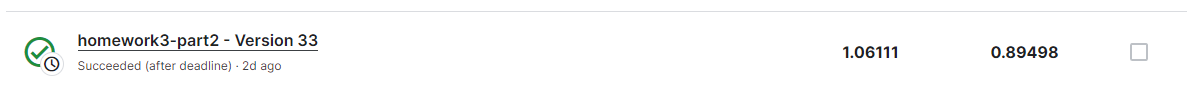

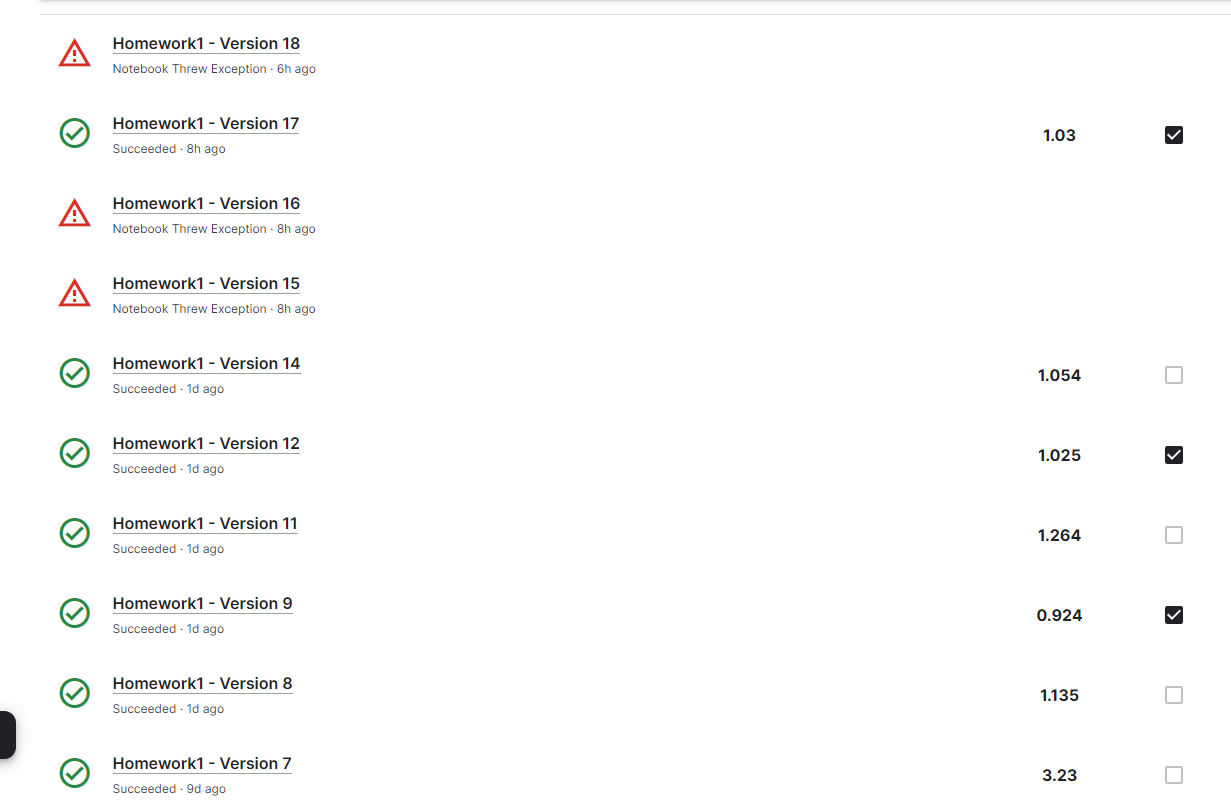